In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import time
import glob
import scipy
import numba
import torch
import tqdm
import numpy as np
import pandas as pd

import seaborn as sns

import scipy.io as sio
from scipy.stats import moment
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import multiprocess as mp
from toolz.curried import pipe, curry

In [3]:
import ase.io as aio
from ase import Atoms
from ase.neighborlist import neighbor_list

from asap3.analysis import PTM
from asap3.analysis.localstructure import RestrictedCNA, GuessLatticeConstant

from sklearn.decomposition import PCA

In [4]:
import utilities as utils

In [5]:
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.color'] = 'r'
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = [6.0, 4.50]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

In [50]:
folder = "structs"
if not os.path.exists(folder):
    os.mkdir(folder)
    
if not os.path.exists("rmsds"):
    os.mkdir("rmsds")

In [15]:
runs = np.loadtxt("runs.txt").astype(int)
runs.shape

(77,)

## Load lammps dump file

In [51]:
%%time
run = runs[1]
f_dump = "../new-data/CK_Cu_ACC_DUMP/dump.arc.{}".format(run)
atoms = aio.read(f_dump, format="lammps-dump-text")
atoms.set_pbc([1, 1, 1])
f_struct = "{}/sdump.arc.{}_atom.pkl".format(folder, run)
utils.save_file(f_struct, obj=atoms)

CPU times: user 32.9 s, sys: 1.31 s, total: 34.2 s
Wall time: 34.8 s


## Utilize PTM to identify 
[link to PTM documentation](https://wiki.fysik.dtu.dk/asap/Local%20crystalline%20order)

In [20]:
%%time
ptm = PTM(atoms, rmsd_max=0.10, cutoff=8)
tags = ptm['structure']
atoms.set_tags(tags)


idx = np.where(tags != 1)[0]
print(len(idx))
coords_irr = atoms.get_positions()[idx]

rmsds = ptm['rmsd']

f_rmsd = "{}/sdump.arc.{}_rmsd.pkl".format("rmsd", run)
utils.save_file(f_rmsd, obj=atoms)

0
CPU times: user 1min 30s, sys: 514 ms, total: 1min 30s
Wall time: 1min 30s


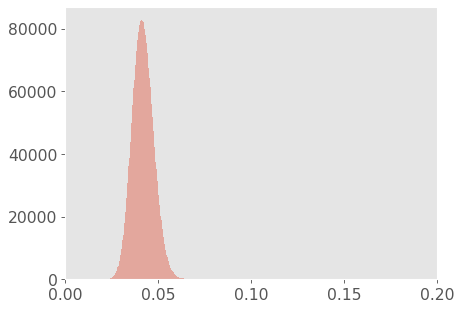

In [31]:
sns.distplot(rmsds, kde=False, bins=200)
plt.xlim([0.0, 0.20])
plt.grid(False)
plt.show()

In [57]:
rmsds.mean() + 6 * rmsds.std()

0.07624477948592782

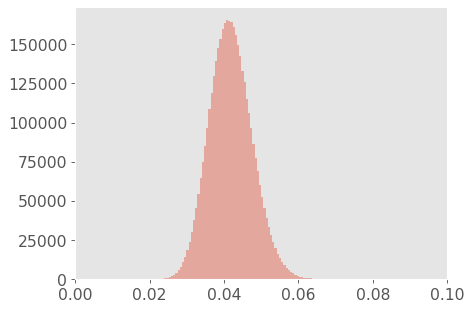

In [32]:
sns.distplot(rmsds, kde=False, bins=100)
plt.xlim([0.0, 0.10])
plt.grid(False)
plt.show()

In [21]:
pca = PCA(n_components=3)
scores = pca.fit_transform(coords_irr)

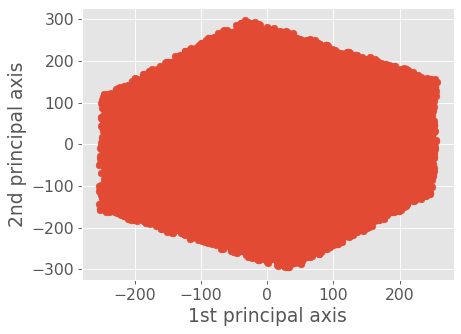

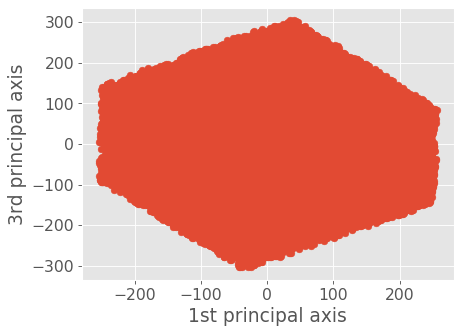

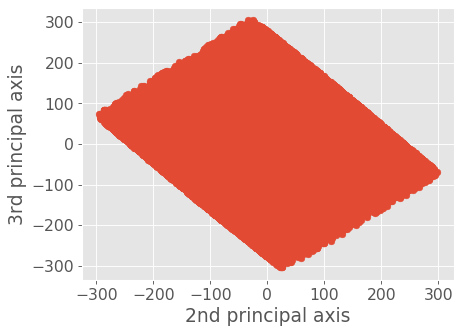

In [22]:
plt.scatter(scores[:,0], scores[:,1])
plt.xlabel("1st principal axis")
plt.ylabel("2nd principal axis")
plt.show()

plt.scatter(scores[:,0], scores[:,2])
plt.xlabel("1st principal axis")
plt.ylabel("3rd principal axis")
plt.show()

plt.scatter(scores[:,1], scores[:,2])
plt.xlabel("2nd principal axis")
plt.ylabel("3rd principal axis")
plt.show()

In [63]:
def save_struct_data(run):
    
    f_dump = "../new-data/CK_Cu_ACC_DUMP/dump.arc.{}".format(run)
    print(f_dump)
    
    atoms = aio.read(f_dump, format="lammps-dump-text")
    atoms.set_pbc([1, 1, 1])
    ptm = PTM(atoms, rmsd_max=0.10, cutoff=8)
    atoms.set_tags(ptm['structure'])
    
    f_struct = "{}/dump.arc.{}_atom.pkl".format(folder, run)
    utils.save_file(f_struct, obj=atoms)
    
    rmsds = ptm['rmsd']

    f_rmsd = "{}/dump.arc.{}_rmsd.pkl".format("rmsds", run)
    utils.save_file(f_rmsd, obj=atoms)

In [61]:
%%time
save_struct_data(runs[0])

CPU times: user 2min 8s, sys: 2.05 s, total: 2min 10s
Wall time: 2min 10s


In [ ]:
import multiprocessing as mp
n_proc = 4
with mp.Pool(n_proc) as p:
    print(p.map(save_struct_data, runs))

../new-data/CK_Cu_ACC_DUMP/dump.arc.0
../new-data/CK_Cu_ACC_DUMP/dump.arc.2500
../new-data/CK_Cu_ACC_DUMP/dump.arc.5000
../new-data/CK_Cu_ACC_DUMP/dump.arc.7500
../new-data/CK_Cu_ACC_DUMP/dump.arc.500
../new-data/CK_Cu_ACC_DUMP/dump.arc.3000
../new-data/CK_Cu_ACC_DUMP/dump.arc.5500
../new-data/CK_Cu_ACC_DUMP/dump.arc.8000
../new-data/CK_Cu_ACC_DUMP/dump.arc.1000
../new-data/CK_Cu_ACC_DUMP/dump.arc.3500
../new-data/CK_Cu_ACC_DUMP/dump.arc.6000
../new-data/CK_Cu_ACC_DUMP/dump.arc.8500
../new-data/CK_Cu_ACC_DUMP/dump.arc.1500
../new-data/CK_Cu_ACC_DUMP/dump.arc.4000
../new-data/CK_Cu_ACC_DUMP/dump.arc.6500
../new-data/CK_Cu_ACC_DUMP/dump.arc.9000
../new-data/CK_Cu_ACC_DUMP/dump.arc.2000
../new-data/CK_Cu_ACC_DUMP/dump.arc.4500
../new-data/CK_Cu_ACC_DUMP/dump.arc.7000
../new-data/CK_Cu_ACC_DUMP/dump.arc.9500
../new-data/CK_Cu_ACC_DUMP/dump.arc.10000
../new-data/CK_Cu_ACC_DUMP/dump.arc.12500
../new-data/CK_Cu_ACC_DUMP/dump.arc.15000
../new-data/CK_Cu_ACC_DUMP/dump.arc.17500
../new-data/CK_C